In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

sys.path.append("/work/gallim/SIMStudies/wipfs/preproce/electrons")
from preprocessing import saturation

In [3]:
input_dir = "/work/gallim/SIMStudies/FlashSimStudies/preprocessing/extracted_photons"
files = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:10]

df = dd.read_parquet(files).compute()

In [4]:
df.columns

Index(['GenPho_pt', 'GenPho_eta', 'GenPho_phi', 'GenPho_status',
       'GenPho_statusFlags', 'RecoPho_pt', 'RecoPho_eta', 'RecoPho_phi',
       'RecoPho_mass', 'RecoPho_r9', 'RecoPho_sieie', 'RecoPho_eCorr',
       'RecoPho_energyErr', 'RecoPho_hoe', 'RecoPho_mvaID',
       'RecoPho_pfRelIso03_all', 'RecoPho_pfRelIso03_chg',
       'GenPhoGenEle_deltar', 'GenPhoGenEle_deltaphi', 'GenPhoGenEle_deltaeta',
       'GenPhoGenEle_ptratio', 'GenPhoGenJet_deltar', 'GenPhoGenJet_deltaphi',
       'GenPhoGenJet_deltaeta', 'GenPhoGenJet_ptratio', 'RecoPhoGenPho_deltar',
       'RecoPhoGenPho_deltaphi', 'RecoPhoGenPho_deltaeta',
       'RecoPhoGenPho_ptratio', 'ClosestGenJet_pt', 'ClosestGenJet_mass',
       'PU_nTrueInt', 'PU_nPU', 'PU_gpudensity', 'PU_pudensity', 'PU_sumEOOT',
       'PU_sumLOOT'],
      dtype='object')

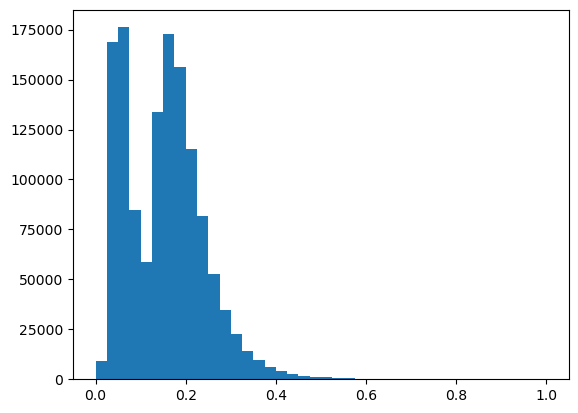

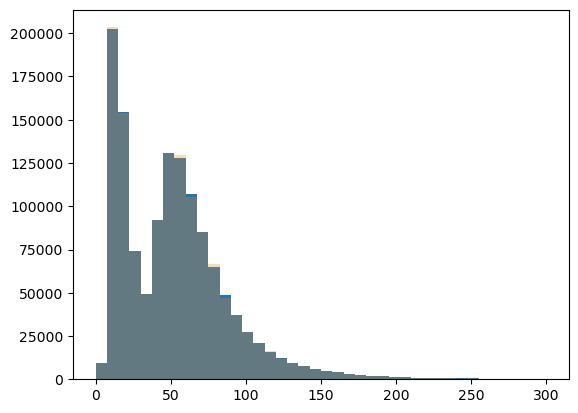

In [47]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log1p(x*0.01), inverse_func=lambda x: np.expm1(x)/0.01)),
        ('scaler', MinMaxScaler((0, 1)))
    ]
)
orig_rng = (0, 300)
var = df['GenPho_pt'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

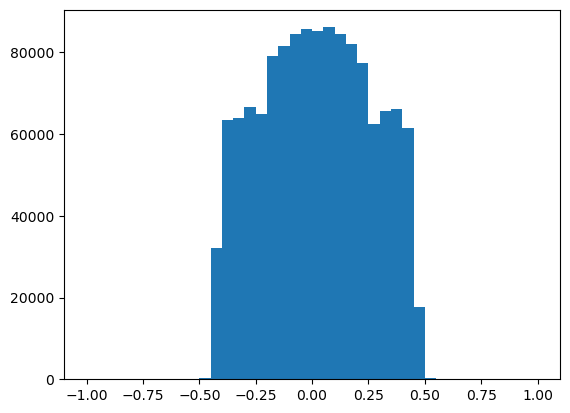

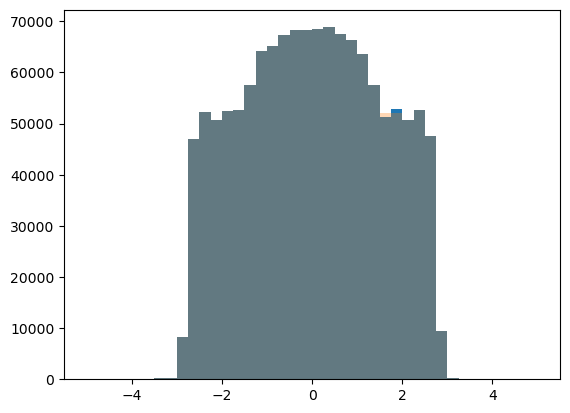

In [53]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)
orig_rng = (-5, 5)
var = df['GenPho_eta'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

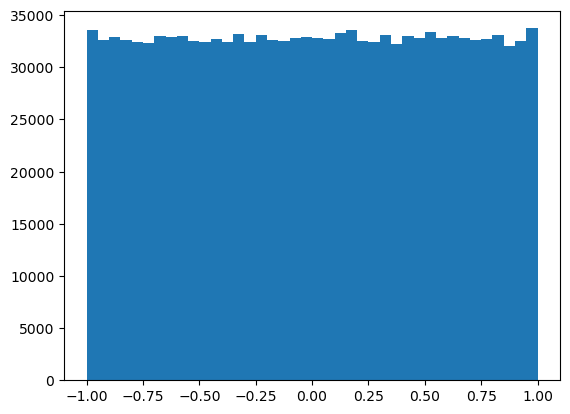

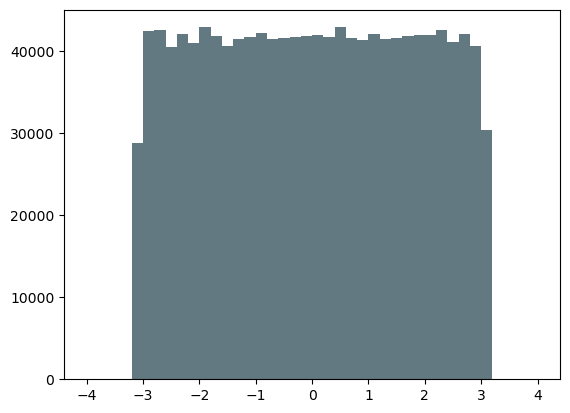

In [55]:
pipe = Pipeline(
    [
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)
orig_rng = (-4, 4)
var = df['GenPho_phi'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

[ 1 23 44]


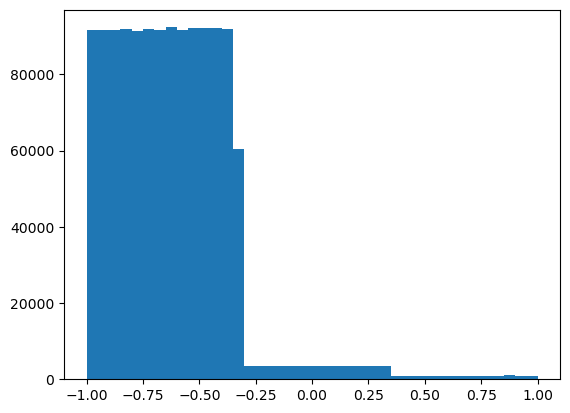

[ 1 23 44]


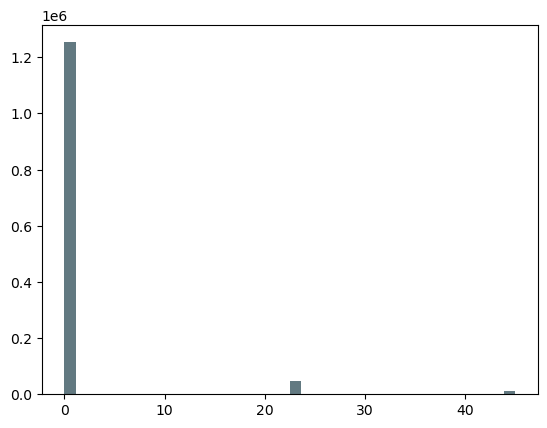

In [193]:
from sklearn.base import TransformerMixin, BaseEstimator

"""
class Smearer(TransformerMixin, BaseEstimator):
    def __init__(self, kind):
        if kind not in ['gaus', 'uniform']:
            raise ValueError
        self.kind = kind
        
    def half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(([arr[0] - half_diffs[0]], 
                                  arr[:-1] + half_diffs, 
                                  [arr[-1] + half_diffs[-1]]))
        return result
    
    def fit(self, X, y=None):
        self.values = np.unique(X)
        self.half_distances = half_distances(self.values)
        self.half_widths = np.array([np.abs(i - j) for i, j in zip(self.half_distances[:-1], self.half_distances[1:])])
    
    def transform(self, X, y=None):
        self.numbers = np.unique(X)
        ranges = {}
        for i, n in enumerate(self.numbers):
            if i == 0:
                half_width = abs(self.numbers[i+1] - n) / 2
                ranges[n] = [n - half_width, n + half_width]
            elif i == (len(self.numbers) - 1):
                half_width = abs(n - self.numbers[i - 1]) / 2
                ranges[n] = [n - half_width, n + half_width]
            else:
                half_width_left = abs(n - self.numbers[i - 1]) / 2
                half_width_right = abs(self.numbers[i + 1] - n) / 2
                ranges[n] = [n - half_width_left, n + half_width_right]

        return np.array([np.random.uniform(ranges[int(r)][0], ranges[int(r)][1]) for r in X]).reshape(-1, 1)
    
    def inverse_transform(self, X, y=None):
        new_arr = []
        for x in X:
            index = np.argmin(np.abs(self.numbers - x))
            new_arr.append(self.numbers[index])
        return np.array(new_arr).reshape(-1, 1)
"""

class Smearer(TransformerMixin, BaseEstimator):
    def __init__(self, kind):
        if kind not in ['gaus', 'uniform']:
            raise ValueError
        self.kind = kind
        
    def get_half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(([arr[0] - half_diffs[0]], 
                                  arr[:-1] + half_diffs, 
                                  [arr[-1] + half_diffs[-1]]))
        return result
    
    def count_occurrences(self, arr):
        unique_values = np.unique(arr)
        counts = np.bincount(arr[:, 0])
        return dict(zip(unique_values, counts[unique_values]))
    
    def find_closest_numbers(self, sample, numbers):
        closest_indices = np.argmin(np.abs(sample[:, 0] - numbers[:, np.newaxis]), axis=0)
        return numbers[closest_indices]
    
    def fit(self, X, y=None):
        self.occurrences = self.count_occurrences(X)
        self.values = np.array(list(self.occurrences.keys()))
        self.half_distances = self.get_half_distances(self.values) # one more item wrt occurrances, values and half_widths
        self.half_widths = np.array([np.abs(i - j) for i, j in zip(self.half_distances[:-1], self.half_distances[1:])])
        
        return self
    
    def transform(self, X, y=None):
        new_sub_arrs = []
        for idx, (number, occ) in enumerate(self.occurrences.items()):
            if self.kind == 'uniform':
                new_sub_arrs.append(np.random.uniform(low=self.half_distances[idx], high=self.half_distances[idx+1], size=occ))
            elif self.kind == 'gaus':
                scale = self.half_widths[idx] / 2
                new_sub_arrs.append(np.random.normal(loc=number, scale=scale, size=occ))
        arr = np.concatenate(new_sub_arrs).reshape(-1, 1)
        np.random.shuffle(arr)
        return arr
    
    def inverse_transform(self, X, y=None):
        return self.find_closest_numbers(X, self.values).reshape(-1, 1)


pipe = Pipeline(
    [
        ('smearer', Smearer('uniform')),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 45)
var = df['GenPho_status'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

In [188]:
import numpy as np

def find_closest_numbers(sample, numbers):
    print(sample.shape)
    print(numbers.shape)
    closest_indices = np.argmin(np.abs(sample - numbers[:, np.newaxis]), axis=0)
    return numbers[closest_indices]

sample = np.array([1.2, 3.5, 6.8, 9.1, 4.4, 55])
numbers = np.array([1, 4, 7, 10])
closest = find_closest_numbers(sample, numbers)

print(closest)  # Output: [1 4 7 10]


(6,)
(4,)
[ 1  4  7 10  4 10]


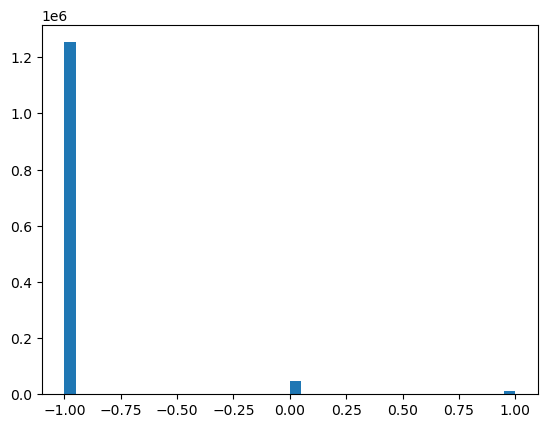

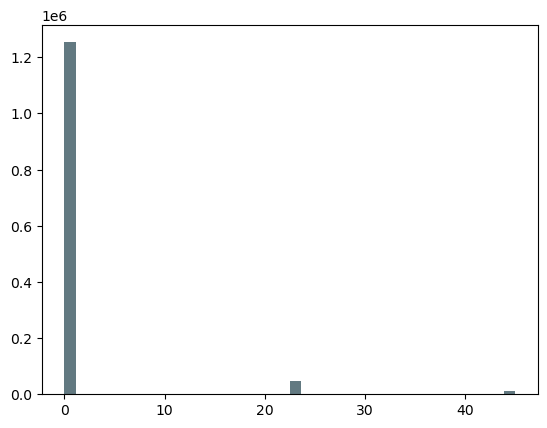

In [78]:
from scipy.ndimage.filters import uniform_filter1d

pipe = Pipeline(
    [
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*100), inverse_func=lambda x: (np.tan(x))/100)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 45)
var = df['GenPho_status'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

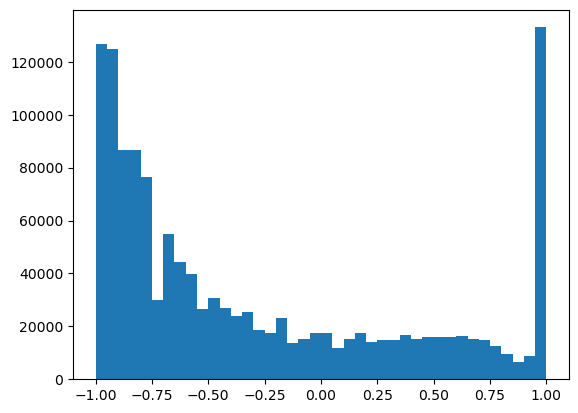

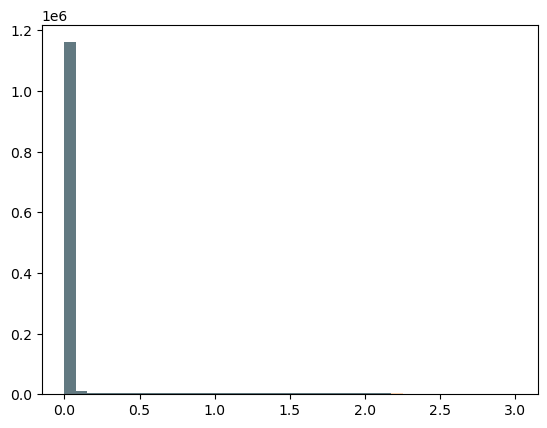

In [21]:
pipe = Pipeline(
    [
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*100), inverse_func=lambda x: (np.tan(x))/100)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 3)
var = df['RecoPhoGenPho_deltaeta'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

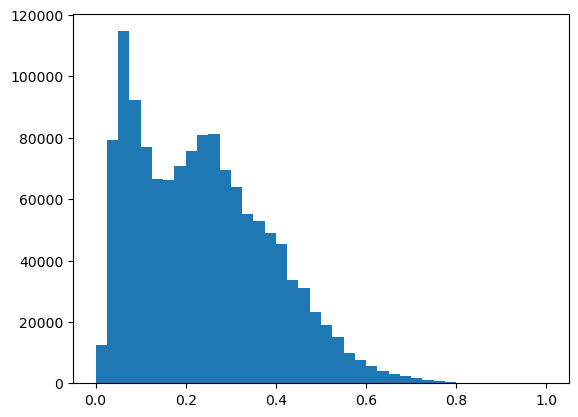

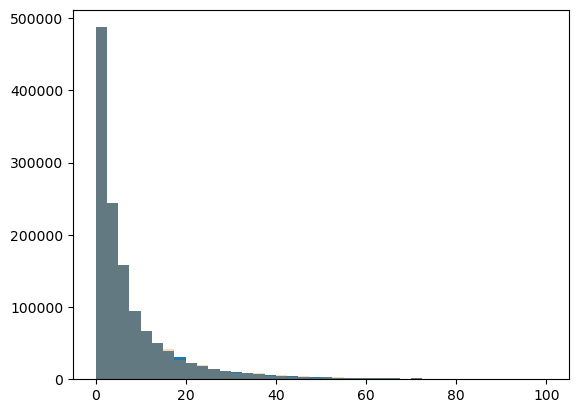

In [17]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log1p(x), inverse_func=lambda x: np.expm1(x))),
        ('scaler', MinMaxScaler((0, 1)))
    ]
)

orig_rng = (0, 100)
var = df['RecoPho_energyErr'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

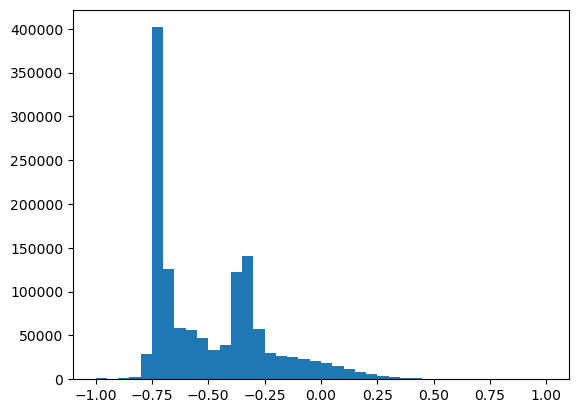

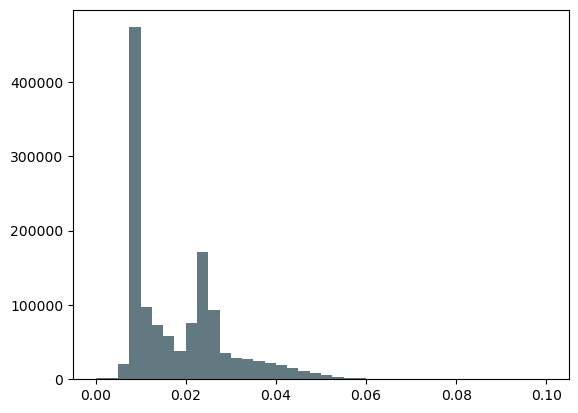

In [9]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log(x*10 + 1e-1), inverse_func=lambda x: (np.exp(x) - 1e-1)/10)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x - 1.25), inverse_func=lambda x: (np.tan(x) + 1.25))),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

orig_rng = (0, 0.1)
var = df['RecoPho_sieie'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40);
plt.show()
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=40, range=orig_rng);
plt.hist(old_var, bins=40, range=orig_rng, alpha=0.3);

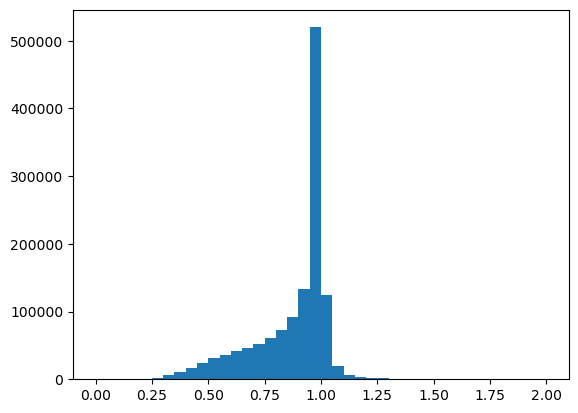

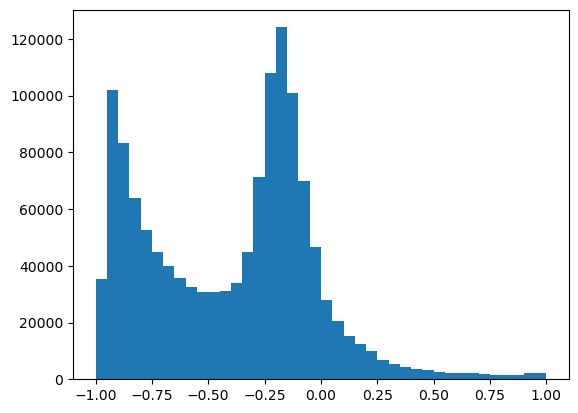

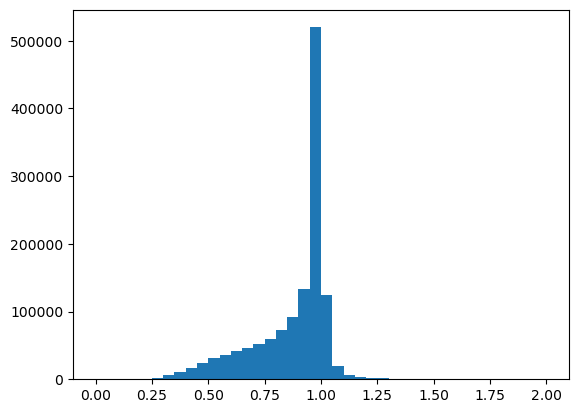

In [61]:
pipe = Pipeline(
    [
        ('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*10 - 0.15), inverse_func=lambda x: (np.tan(x) + 0.15)/10)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

r9 = df['RecoPho_r9'].values
plt.hist(r9, bins=40, range=(0, 2));
plt.show()
new_r9 = pipe.fit_transform(r9.reshape(-1, 1))
plt.hist(new_r9, bins=40);
plt.show()
old_r9 = pipe.inverse_transform(new_r9)
plt.hist(old_r9, bins=40, range=(0, 2));

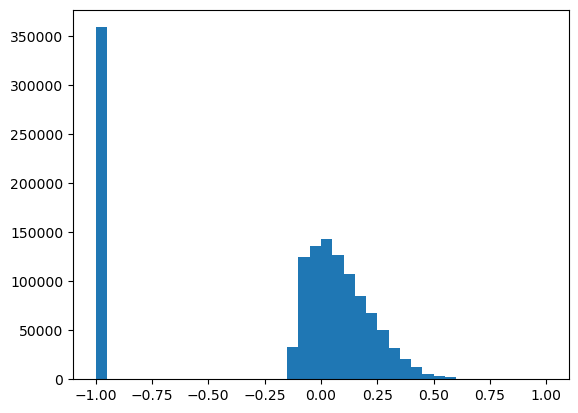

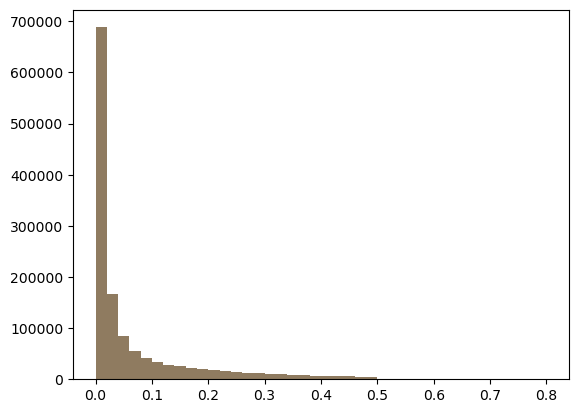

In [87]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        #('log_trans', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
        #('pow', PowerTransformer()),
        ('qtgaus', QuantileTransformer(output_distribution="normal", n_quantiles=1000, random_state=0)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

var = df['RecoPho_hoe'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40)
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=40, range=(0, 0.8));
plt.hist(var, bins=40, range=(0, 0.8), alpha=0.5);

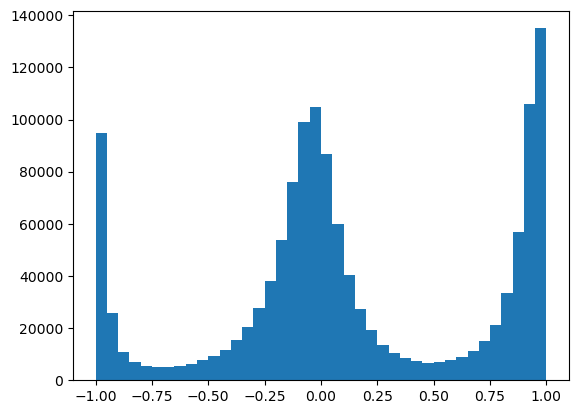

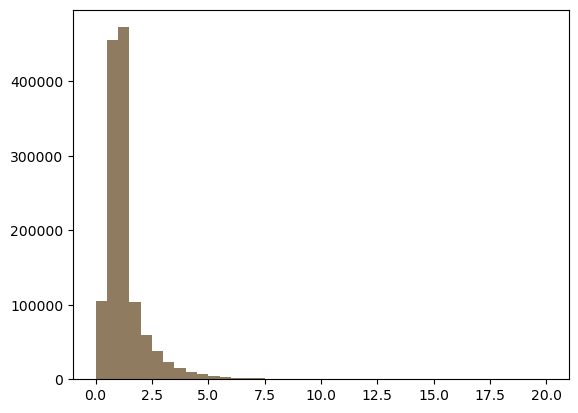

In [95]:
pipe = Pipeline(
    [
        #('log_trans', FunctionTransformer(lambda x: np.log(x + 1e-2), inverse_func=lambda x: np.exp(x) - 1e-2)),
        ('arctan_trans', FunctionTransformer(lambda x: np.arctan(x*10 - 10), inverse_func=lambda x: (np.tan(x) + 10)/10)),
        #('log_trans', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
        ('scaler', MinMaxScaler((-1, 1)))
    ]
)

var = df['RecoPhoGenPho_ptratio'].values
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=40)
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(old_var, bins=40, range=(0, 20));
plt.hist(var, bins=40, range=(0, 20), alpha=0.5);